In [1]:
import numpy as np
import sys
sys.path.insert(0, '/home/sumanthraikar/Desktop/Casual Learning/pyadi_iio')
import adi 
from utils import Tx_setting, Rx_setting
import matplotlib.pyplot as plt
from fec_blocks import FECHamming
import pickle
import math


import torch 
import torch.nn as nn
from torch.autograd import Variable
from model import NN_Symbol_demapper, NN_Symbol_Mapper

In [ ]:
#Minimum hamming distance loss function
class Min_hamming_distance(nn.Module):

    def __init__(self, alpha=1):
        super(Min_hamming_distance, self).__init__()
        self.alpha = alpha

    def forward(self, encoder):
        codebook = encoder(torch.eye(2**self.k))
        return -self.alpha*torch.cdist(codebook, codebook).flatten().kthvalue((2**self.k)+1)

In [ ]:
class Communication_system_training:

    def __init__(self, n,k,act_fn, batch_size,sps=20, lr=1e-3):
        self.n = n
        self.k = k
        self.act_fn = act_fn
        self.batch_size = batch_size
        self.sps = sps
        self.lr = lr

        #----------------------Tx_definition------------------------- 
        self.sample_rate = 1e6
        self.center_freq = 915e6 

        self.encoder = NN_Symbol_Mapper(act_fn=self.act_fn, n=self.n, k = self.k)
        self.encoder.mapper.load_state_dict(torch.load('alternate_AE_encoder_model_k4N7.pth'))

        self.pluto_tx = Tx_setting(sample_rate=self.sample_rate,center_freq=self.center_freq)
        self.E_optimizer = torch.optim.Adam(
        self.encoder.parameters(), lr=self.lr)

        #----------------------Rx definition-----------------------------
        self.pluto_rx = Rx_setting(sample_rate=self.sample_rate,center_freq=self.center_freq,data_length=self.n, sps=self.sps)
        self.demapper = NN_Symbol_demapper(act_fn=self.act_fn, n=self.n, k=self.k)
        self.demapper.s2b_mapper.load_state_dict(torch.load('alterante_AE_decoder_model_k4N7.pth'))
        self.E_loss = nn.CrossEntropyLoss()
        self.D_loss = nn.CrossEntropyLoss()
        self.D_optimizer = torch.optim.Adam(
        self.demapper.parameters(), lr=self.lr)

    def encoder_loss(self):
        return torch.cdist(self.encoder(torch.eye(2**self.k)), self.encoder(torch.eye(2**self.k))).mean()

    

    def one_hot_converter(self,array):
    #----Accepts a matrix in binary format and converts to one_hot tensor form---
        batch_size, code_length = array.shape
        one_hot = np.zeros((batch_size, 2**code_length))
        if (array!=None).any():
            b = [''.join([str(int(j)) for j in i]) for i in array]
            c = [int(i,2) for i in b]
            one_hot[np.arange(batch_size), c] = 1

            return torch.from_numpy(one_hot.astype('float32'))

        else:
            return torch.from_numpy(one_hot.astype('float32'))
        

    def data_generate(self):
        #-----------------------Data generation-----------------------
        data_bits = np.zeros((self.batch_size, self.k))
        data_ints = np.random.randint(low=0, high=2**self.k, size=self.batch_size)

        for data,i in zip(data_ints,range(self.batch_size)):
            data_bits[i] = np.array([int(j) for j in np.binary_repr(data, self.k)])

        kb_one_hot_data = self.one_hot_converter(data_bits)

    

        return kb_one_hot_data.requires_grad_(True)
        

    def encoder_training(self, count):

        self.encoder.train()
        avg_loss=0.0
        iters=100
        for e in range(iters):
            kb_one_hot_data = self.data_generate()
            
            encoded_data_bits = self.encoder(kb_one_hot_data)
            received_data_symbols = torch.zeros((self.batch_size, self.n))

            for pt,i in zip(encoded_data_bits.detach().numpy(), range(self.batch_size)):
                
                self.pluto_tx.Modulation(bits=pt, sps=self.sps, repeat_tx=True, plot=False)

                received_symbols=self.pluto_rx.demodulate(plot=False)
                received_data_symbols[i] = torch.from_numpy(received_symbols.astype('float32'))
                self.pluto_tx.sdr.tx_destroy_buffer()

            

            
            decoded_data = self.demapper(received_data_symbols)
            loss = self.E_loss(decoded_data, torch.argmax(kb_one_hot_data, 1))
            self.E_optimizer.zero_grad()
            loss.backward()
            self.E_optimizer.step()
            avg_loss+=loss
        print('E_Epoch:{}, ELoss:{:.4f}'.format(e+1,float(avg_loss/iters)))
        if (avg_loss/iters) < 0.1:
            torch.save(self.encoder.mapper.state_dict(), f'alternate_trained_models/pluto_alternate_AE_encoder_model_k{self.k}N{self.n}c{count}.pth')

    
    def decoder_training(self, count):

        self.demapper.train()
        avg_loss=0.0
        iters=100
        for e in range(iters):
            kb_one_hot_data = self.data_generate()
            # print(kb_one_hot_data)
            encoded_data_bits = self.encoder(kb_one_hot_data)
            # print(encoded_data_bits)
            received_data_symbols = torch.zeros((self.batch_size, self.n))

            for pt,i in zip(encoded_data_bits.detach().numpy(), range(self.batch_size)):
                
                self.pluto_tx.Modulation(bits=pt, sps=self.sps, repeat_tx=True, plot=False)

                received_symbols=self.pluto_rx.demodulate(plot=False)
                received_data_symbols[i] = torch.from_numpy(received_symbols.astype('float64'))
                self.pluto_tx.sdr.tx_destroy_buffer()

            
            # print(received_data_symbols)
            received_data_symbols.requires_grad_(True)
            decoded_data = self.demapper(received_data_symbols)
            loss = self.D_loss(decoded_data, torch.argmax(kb_one_hot_data, 1))
            self.D_optimizer.zero_grad()
            loss.backward()
            self.D_optimizer.step()
            avg_loss+=loss

        print('DEpoch:{}, DLoss:{:.4f}'.format(e+1,float(avg_loss/iters)))
        if (avg_loss/iters) < 0.1:
            torch.save(self.demapper.s2b_mapper.state_dict(), f'alternate_trained_models/pluto_alternate_AE_decoder_model_k{self.k}N{self.n}c{count}.pth')

    
    def trainer(self):

        for i in range(120):
            if i%2==1:
                self.encoder_training(i)
            else:
                self.decoder_training(i)


In [ ]:
n=7
k=4
act_fn = nn.ReLU
batch_size = 100

learner = Communication_system_training(n=n, k=k, act_fn=act_fn, batch_size=batch_size)
learner.trainer()


In [ ]:
#Train decoder, encoder
#trained model in simulation 
# start real time training with pretrained models

# torch.save(learner.encoder.mapper.state_dict(), f'pluto_alternate_AE_encoder_model_k{k}N{n}.pth')
# torch.save(learner.demapper.s2b_mapper.state_dict(), f'pluto_alterante_AE_decoder_model_k{k}N{n}.pth')

In [ ]:
d_loss = np.array([1.3845, 0.6080, 0.3673,0.2761,0.2222, 0.1872,0.1592,0.1386,0.1225,0.1097,0.0974,0.0880,0.0790,0.0672,0.0605,0.0551,0.0490,0.0435,0.0401])
e_loss = np.array([0.8672,0.4317,0.3100,0.2433,0.2062,0.1727,0.1486,0.1285,0.1133,0.1046,0.0918, 0.0802,0.0759,0.0717, 0.0542,0.0515,0.0466,0.0424])
plt.plot(d_loss,"m^-", label="Decoder training CE loss")
plt.plot(e_loss, "gs-", label = "Encoder training CE loss")
plt.show()

In [2]:
class Communication_system_training:

    def __init__(self, n,k,act_fn, batch_size,sps=20, lr=1e-3):
        self.n = n
        self.k = k
        self.act_fn = act_fn
        self.batch_size = batch_size
        self.sps = sps
        self.lr = lr

        #----------------------Tx_definition------------------------- 
        self.sample_rate = 1e6
        self.center_freq = 915e6 

        self.encoder = NN_Symbol_Mapper(act_fn=self.act_fn, n=self.n, k = self.k)
        self.encoder.mapper.load_state_dict(torch.load('alternate_AE_encoder_model_k4N7.pth'))

        self.pluto_tx = Tx_setting(sample_rate=self.sample_rate,center_freq=self.center_freq)
        self.E_optimizer = torch.optim.Adam(
        self.encoder.parameters(), lr=self.lr)

        #----------------------Rx definition-----------------------------
        self.pluto_rx = Rx_setting(sample_rate=self.sample_rate,center_freq=self.center_freq,data_length=self.n, sps=self.sps)
        self.demapper = NN_Symbol_demapper(act_fn=self.act_fn, n=self.n, k=self.k)
        self.demapper.s2b_mapper.load_state_dict(torch.load('alterante_AE_decoder_model_k4N7.pth'))
        self.E_loss = nn.CrossEntropyLoss()
        self.D_loss = nn.CrossEntropyLoss()
        self.D_optimizer = torch.optim.Adam(
        self.demapper.parameters(), lr=self.lr)
    

    def one_hot_converter(self,array):
    #----Accepts a matrix in binary format and converts to one_hot tensor form---
        batch_size, code_length = array.shape
        one_hot = np.zeros((batch_size, 2**code_length))
        if (array!=None).any():
            b = [''.join([str(int(j)) for j in i]) for i in array]
            c = [int(i,2) for i in b]
            one_hot[np.arange(batch_size), c] = 1

            return torch.from_numpy(one_hot.astype('float32'))

        else:
            return torch.from_numpy(one_hot.astype('float32'))
        

    def data_generate(self):
        #-----------------------Data generation-----------------------
        data_bits = np.zeros((self.batch_size, self.k))
        data_ints = np.random.randint(low=0, high=2**self.k, size=self.batch_size)

        for data,i in zip(data_ints,range(self.batch_size)):
            data_bits[i] = np.array([int(j) for j in np.binary_repr(data, self.k)])

        kb_one_hot_data = self.one_hot_converter(data_bits)

    

        return kb_one_hot_data.requires_grad_(True)
        

    def encoder_training(self, count):

        self.encoder.train()
        avg_loss=0.0
        iters=100
        for e in range(iters):
            kb_one_hot_data = self.data_generate()
            
            encoded_data_bits = self.encoder(kb_one_hot_data)
            received_data_symbols = torch.zeros((self.batch_size, self.n))

            for pt,i in zip(encoded_data_bits.detach().numpy(), range(self.batch_size)):
                
                self.pluto_tx.Modulation(bits=pt, sps=self.sps, repeat_tx=True, plot=False)

                received_symbols=self.pluto_rx.demodulate(plot=False)
                received_data_symbols[i] = torch.from_numpy(received_symbols.astype('float32'))
                self.pluto_tx.sdr.tx_destroy_buffer()

            

            
            decoded_data = self.demapper(received_data_symbols)
            loss = self.E_loss(decoded_data, torch.argmax(kb_one_hot_data, 1))
            self.E_optimizer.zero_grad()
            loss.backward()
            self.E_optimizer.step()
            avg_loss+=loss
        print('E_Epoch:{}, ELoss:{:.4f}'.format(e+1,float(avg_loss/iters)))
        if (avg_loss/iters) < 0.1:
            torch.save(self.encoder.mapper.state_dict(), f'alternate_trained_models/pluto_alternate_AE_encoder_model_k{self.k}N{self.n}c{count}.pth')

    
    def decoder_training(self, count):

        self.demapper.train()
        avg_loss=0.0
        iters=100
        for e in range(iters):
            kb_one_hot_data = self.data_generate()
            # print(kb_one_hot_data)
            encoded_data_bits = self.encoder(kb_one_hot_data)
            # print(encoded_data_bits)
            received_data_symbols = torch.zeros((self.batch_size, self.n))

            for pt,i in zip(encoded_data_bits.detach().numpy(), range(self.batch_size)):
                
                self.pluto_tx.Modulation(bits=pt, sps=self.sps, repeat_tx=True, plot=False)

                received_symbols=self.pluto_rx.demodulate(plot=False)
                received_data_symbols[i] = torch.from_numpy(received_symbols.astype('float64'))
                self.pluto_tx.sdr.tx_destroy_buffer()

            
            # print(received_data_symbols)
            received_data_symbols.requires_grad_(True)
            decoded_data = self.demapper(received_data_symbols)
            loss = self.D_loss(decoded_data, torch.argmax(kb_one_hot_data, 1))
            self.D_optimizer.zero_grad()
            loss.backward()
            self.D_optimizer.step()
            avg_loss+=loss

        print('DEpoch:{}, DLoss:{:.4f}'.format(e+1,float(avg_loss/iters)))
        if (avg_loss/iters) < 0.1:
            torch.save(self.demapper.s2b_mapper.state_dict(), f'alternate_trained_models/pluto_alternate_AE_decoder_model_k{self.k}N{self.n}c{count}.pth')


    def evaluator(self):
        
        self.encoder.mapper.load_state_dict(torch.load('alternate_trained_models/pluto_alternate_AE_encoder_model_k4N7c35.pth'))
        self.demapper.s2b_mapper.load_state_dict(torch.load('alternate_trained_models/pluto_alternate_AE_decoder_model_k4N7c36.pth'))

        self.encoder.eval()
        self.demapper.eval()

        acc = 0.0
        iters = 100
        with torch.no_grad():

            for e in range(iters):
                kb_one_hot_data = self.data_generate()
                kb_one_hot_data.requires_grad_(False)

                encoded_data_bits = self.encoder(kb_one_hot_data)
                received_data_symbols = torch.zeros((self.batch_size, self.n))

                for pt,i in zip(encoded_data_bits.detach().numpy(), range(self.batch_size)):
                    
                    self.pluto_tx.Modulation(bits=pt, sps=self.sps, repeat_tx=True, plot=False)

                    received_symbols=self.pluto_rx.demodulate(plot=False)
                    received_data_symbols[i] = torch.from_numpy(received_symbols.astype('float32'))
                    self.pluto_tx.sdr.tx_destroy_buffer()
                
                decoded_data = self.demapper(received_data_symbols)
                decoded_data = decoded_data.detach().numpy()
                kb_one_hot_data= kb_one_hot_data.detach().numpy()

                pred_output = np.argmax(decoded_data,1)
                accuracy = np.equal(pred_output,np.argmax(kb_one_hot_data,1))
                acc += np.mean(accuracy)

            bler = 1-(acc/(iters))

        return bler
    
    def trainer(self):

        for i in range(120):
            if i%2==1:
                self.encoder_training(i)
            else:
                self.decoder_training(i)

    def evaluation(self):
        itrs = 40
        self.blers = np.zeros((itrs,))
        for i in range(itrs):
            self.blers[i] = self.evaluator()
        return np.mean(self.blers)


In [3]:
n=7
k=4
act_fn = nn.ReLU
batch_size = 100

tester = Communication_system_training(n=n, k=k, act_fn=act_fn, batch_size=batch_size)
bler = tester.evaluation()
print(f'BLER of aletrnately trained NN: {bler}')


BLER of aletrnately trained NN: 0.27640000000000003


In [ ]:
print(tester.encoder(torch.eye(16)))

In [28]:
a = torch.tensor([0,0,1,1,2,2])


torch.return_types.kthvalue(
values=tensor(1),
indices=tensor(2))

In [32]:
enc_values = tester.encoder(torch.eye(16))
# for enc in enc_values[:4]:
#     plt.plot(enc)
a = torch.cdist(enc_values, enc_values).flatten()
torch.kthvalue(a,17)[0]

tensor(0.0812, grad_fn=<KthvalueBackward0>)

In [5]:
enc_values
distance_matrix = np.zeros((16,16))
for i,enc1 in zip(range(16),enc_values):
    for j,enc2 in zip(range(16),enc_values):
        distance_matrix[i,j] = np.linalg.norm(enc1-enc2)
distance_matrix

array([[0.        , 0.32261172, 0.2103274 , 0.15564144, 0.20951006,
        0.51217711, 0.38889956, 0.08116017, 0.15269378, 0.19730514,
        0.38489628, 0.21250346, 0.93465376, 0.37566152, 0.86064446,
        0.39739442],
       [0.32261172, 0.        , 0.15922119, 0.25854859, 0.42362306,
        0.51945448, 0.16667698, 0.38014689, 0.43767682, 0.46078432,
        0.60021621, 0.1695472 , 0.95727563, 0.57905036, 0.70047504,
        0.59046239],
       [0.2103274 , 0.15922119, 0.        , 0.21014559, 0.26648897,
        0.53388536, 0.18854664, 0.25471386, 0.32115415, 0.3228744 ,
        0.46078759, 0.15021954, 0.9629758 , 0.42842516, 0.75405085,
        0.47020191],
       [0.15564144, 0.25854859, 0.21014559, 0.        , 0.32001677,
        0.43411794, 0.35279268, 0.22227189, 0.28145236, 0.32701689,
        0.49463555, 0.13945183, 0.91271269, 0.48042566, 0.83424306,
        0.49403116],
       [0.20951006, 0.42362306, 0.26648897, 0.32001677, 0.        ,
        0.64335233, 0.41713852, 

In [25]:
py_dsit = torch.cdist(tester.encoder(torch.eye(16)), tester.encoder(torch.eye(16)))
# np.array_equal(distance_matrix, py_dsit)
py_dsit.mean()

tensor(0.4561, grad_fn=<MeanBackward0>)

In [ ]:
np.save('alternately_trained_encodercodes_eye_16_input.npy', enc_values)

In [ ]:
tester.demapper(tester.encoder(torch.eye(16))).argmax(1)

In [ ]:
enc_values

In [ ]:
plt.plot(enc_values[2])
plt.plot(enc_values[6])
plt.show()

In [7]:
hamming_enc = np.array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1.],
       [0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 1., 1., 1., 1., 0.],
       [0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 0., 1., 0., 1., 1.],
       [0., 1., 1., 0., 1., 0., 1.],
       [0., 1., 1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1., 1., 1.],
       [1., 0., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0., 0.],
       [1., 0., 1., 1., 0., 0., 1.],
       [1., 1., 0., 0., 0., 0., 1.],
       [1., 1., 0., 1., 1., 0., 0.],
       [1., 1., 1., 0., 0., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1.]])

In [10]:
distance_matrix = np.zeros((16,16))
for i,enc1 in zip(range(16),hamming_enc):
    for j,enc2 in zip(range(16),hamming_enc):
        distance_matrix[i,j] = np.linalg.norm(enc1-enc2)
distance_matrix

array([[0.        , 1.73205081, 1.73205081, 2.        , 1.73205081,
        2.        , 2.        , 1.73205081, 2.        , 1.73205081,
        1.73205081, 2.        , 1.73205081, 2.        , 2.        ,
        2.64575131],
       [1.73205081, 0.        , 2.        , 1.73205081, 2.        ,
        1.73205081, 1.73205081, 2.        , 1.73205081, 2.        ,
        2.        , 1.73205081, 2.        , 1.73205081, 2.64575131,
        2.        ],
       [1.73205081, 2.        , 0.        , 1.73205081, 2.        ,
        1.73205081, 1.73205081, 2.        , 1.73205081, 2.        ,
        2.        , 1.73205081, 2.        , 2.64575131, 1.73205081,
        2.        ],
       [2.        , 1.73205081, 1.73205081, 0.        , 1.73205081,
        2.        , 2.        , 1.73205081, 2.        , 1.73205081,
        1.73205081, 2.        , 2.64575131, 2.        , 2.        ,
        1.73205081],
       [1.73205081, 2.        , 2.        , 1.73205081, 0.        ,
        1.73205081, 1.73205081, 

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

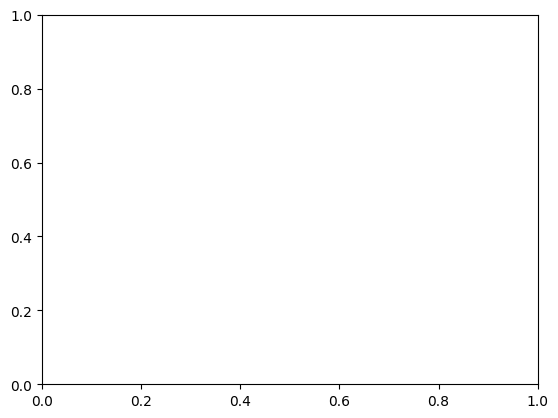

In [33]:
plt.plot(enc_values[2])
plt.plot(hamming_enc[2])
plt.show()